# Lovebird Initial Algorithm

In [166]:
def swap_two(tour, i, j): # red
    new = tour[:]
    if j - i < 4:
        return interchange(new, i, j)

    mid = new[i:j+1]
    k = len(mid) // 2
    seg1 = mid[:k]
    seg2 = mid[k:]
    new[i:i+k] = seg2
    new[i+k:j+1] = seg1
    return new

def flip(tour, i, j): # peach
    new = tour[:]
    new[i:j+1] = reversed(new[i:j+1])
    return new

def interchange(tour, i, j): # green
    new = tour[:]
    new[i], new[j] = new[j], new[i]
    return new

def slide(tour, i, j): # yellow
    new = tour[:]
    city = new.pop(i)
    new.insert(j, city)
    return new

def guided_swap(tour, i, j): # blue
    new = flip(tour, i, j)
    return interchange(new, i, j)

def scramble(tour): # gray
    new = tour[:]
    random.shuffle(new)
    return new

In [167]:
# Fungsi untuk RouletteWheel (untuk pemilihan titik secara probabilistik)
def roulette_wheel(population, fitness):
    total_fitness = sum(fitness)
    selection = random.uniform(0, total_fitness)
    current_sum = 0
    for i, individual in enumerate(population):
        current_sum += fitness[i]
        if current_sum >= selection:
            return individual
    return population[-1]  # fallback jika tidak ada yang terpilih

In [168]:
# ==== helper: bangun mapping kluster -> daftar node (urut sesuai nodes) ====
def _clusters_from_labels(nodes, labels):
    K = int(max(labels)) + 1
    clusters = {c: [] for c in range(K)}
    for n, l in zip(nodes, labels):
        clusters[int(l)].append(n)
    return clusters, K

def lovebird_algorithm_clustered(labels, nodes, maxGeneration, popSize, seed=None):

    rng = random.Random(seed)
    EPS = 1e-12

    # bangun kluster -> daftar node (tetap fix; tidak ada perpindahan antar kluster)
    cluster_nodes, K = _clusters_from_labels(nodes, labels)

    # ---- inisialisasi populasi: permutasi acak per kluster ----
    def _random_individual():
        indiv = []
        for c in range(K):
            r = cluster_nodes[c][:]
            rng.shuffle(r)
            indiv.append(r)
        return indiv

    population = [_random_individual() for _ in range(popSize)]

    # biaya awal populasi (sekali jalan)
    pop_costs = [sum(total_distance(r) for r in ind) for ind in population]

    # best awal
    best_idx = min(range(popSize), key=lambda i: pop_costs[i])
    best_solution = [r[:] for r in population[best_idx]]
    best_fitness = pop_costs[best_idx]
    history = [best_fitness]

    # ---- GA Loop ----
    for g in range(maxGeneration):
        # fitness = 1/cost
        fitness = [1.0/c if c > 0 else 1e9 for c in pop_costs]

        new_population = []
        new_costs = []

        for _ in range(popSize):
            # -------- selection: roulette --------
            parent = roulette_wheel(population, fitness)

            # salin individu (list of routes)
            T = [r[:] for r in parent]

            # ----- mutation: pilih kluster acak, mutasi satu rute -----
            v = rng.randrange(K) if K > 0 else 0
            r = T[v]
            L = len(r)
            if L > 1:
                if rng.random() < 0.9 and L >= 2:
                    i_idx, j_idx = sorted(rng.sample(range(L), 2))
                    op = rng.choice([1, 2, 3, 4, 5])
                    if op == 1:
                        r = swap_two(r, i_idx, j_idx)
                    elif op == 2:
                        r = flip(r, i_idx, j_idx)
                    elif op == 3:
                        r = interchange(r, i_idx, j_idx)
                    elif op == 4:
                        r = slide(r, i_idx, j_idx)
                    else:
                        r = guided_swap(r, i_idx, j_idx)
                else:
                    r = scramble(r)
                T[v] = r

            # hitung biaya awal kandidat
            route_costs = [total_distance(rr) for rr in T]
            total_cost = float(sum(route_costs))

            # ---------- local search per kluster (first-improvement) ----------
            def _improve_route(route, current_cost):
                """apply SWAP lalu 2-OPT (FLIP) circular; return (route_baru, delta_total)"""
                Lr = len(route)
                if Lr <= 2:
                    return route, 0.0

                improved_outer = True
                total_delta = 0.0

                while improved_outer:
                    improved_outer = False

                    # ---- SWAP circular ----
                    made_swap = True
                    while made_swap:
                        made_swap = False
                        if Lr <= 2:
                            break
                        accepted = False
                        i = 0
                        while i < Lr - 1 and not accepted:
                            j = i + 1
                            while j < Lr and not accepted:
                                a_idx, c_idx = i, j
                                aL = route[(a_idx - 1) % Lr]
                                a  = route[a_idx]
                                b  = route[(a_idx + 1) % Lr]
                                cL = route[(c_idx - 1) % Lr]
                                c  = route[c_idx]
                                d  = route[(c_idx + 1) % Lr]

                                adjacent = (c_idx == a_idx + 1) or (a_idx == 0 and c_idx == Lr - 1)
                                if adjacent:
                                    if c_idx == a_idx + 1:
                                        old = D[idx[aL], idx[a]] + D[idx[a], idx[c]] + D[idx[c], idx[d]]
                                        new = D[idx[aL], idx[c]] + D[idx[c], idx[a]] + D[idx[a], idx[d]]
                                    else:
                                        old = D[idx[cL], idx[c]] + D[idx[c], idx[a]] + D[idx[a], idx[b]]
                                        new = D[idx[cL], idx[a]] + D[idx[a], idx[c]] + D[idx[c], idx[b]]
                                else:
                                    old = (D[idx[aL], idx[a]] + D[idx[a], idx[b]] +
                                           D[idx[cL], idx[c]] + D[idx[c], idx[d]])
                                    new = (D[idx[aL], idx[c]] + D[idx[c], idx[b]] +
                                           D[idx[cL], idx[a]] + D[idx[a], idx[d]])
                                delta = new - old
                                if delta < -EPS:
                                    route[a_idx], route[c_idx] = route[c_idx], route[a_idx]
                                    total_delta += delta
                                    made_swap = True
                                    improved_outer = True
                                    accepted = True
                                else:
                                    j += 1
                            if not accepted:
                                i += 1
                        if made_swap:
                            break  # restart

                    # ---- 2-OPT / FLIP circular ----
                    made_flip = True
                    while made_flip:
                        made_flip = False
                        if Lr <= 2:
                            break
                        accepted = False
                        i = 0
                        while i < Lr - 1 and not accepted:
                            j = i + 1
                            while j < Lr and not accepted:
                                if i == 0 and j == Lr - 1:
                                    j += 1
                                    continue
                                ap = route[(i - 1) % Lr]
                                a  = route[i]
                                c  = route[j]
                                dn = route[(j + 1) % Lr]
                                old = D[idx[ap], idx[a]] + D[idx[c], idx[dn]]
                                new = D[idx[ap], idx[c]] + D[idx[a], idx[dn]]
                                delta = new - old
                                if delta < -EPS:
                                    route[i:j+1] = reversed(route[i:j+1])
                                    total_delta += delta
                                    made_flip = True
                                    improved_outer = True
                                    accepted = True
                                else:
                                    j += 1
                            if not accepted:
                                i += 1
                        if made_flip:
                            break  # restart

                return route, total_delta

            # improve semua kluster
            for v in range(K):
                route_before = T[v]
                route_after, delta = _improve_route(route_before, route_costs[v])
                if delta != 0.0:
                    T[v] = route_after
                    route_costs[v] += delta
                    total_cost += delta

            new_population.append(T)
            new_costs.append(total_cost)

        # elitism
        gen_best_idx = min(range(popSize), key=lambda i: new_costs[i])
        if new_costs[gen_best_idx] < best_fitness - EPS:
            best_fitness = new_costs[gen_best_idx]
            best_solution = [r[:] for r in new_population[gen_best_idx]]

        population = new_population
        pop_costs  = new_costs
        history.append(best_fitness)

    # biaya per kluster untuk best_solution
    per_cluster_costs = [total_distance(r) for r in best_solution]
    # total (float)
    best_fitness = float(sum(per_cluster_costs))
    return best_solution, best_fitness, history, per_cluster_costs


In [169]:
# labels = ...   # hasil KMeans, sejajar dengan nodes
best_sol_l, total_cost_l, hist_l, per_costs_l = lovebird_algorithm_clustered(
    labels, nodes, maxGeneration=10, popSize=10
)

print("Biaya per kluster:", per_costs_l)
print("Total biaya:", total_cost_l)
for i, r in enumerate(best_sol_l, 1):
    print(f"Rute kluster {i} (|r|={len(r)}):", r)

Biaya per kluster: [747.545262145507, 584.971167502174]
Total biaya: 1332.516429647681
Rute kluster 1 (|r|=75): [10, 110, 54, 29, 52, 117, 80, 51, 27, 59, 125, 82, 3, 90, 114, 44, 108, 128, 58, 18, 116, 41, 6, 85, 16, 60, 20, 77, 88, 76, 47, 115, 30, 55, 71, 1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 106, 81, 15, 93, 62, 37, 96, 8, 84, 69, 38, 78, 53, 135, 112, 132]
Rute kluster 2 (|r|=60): [17, 56, 99, 9, 49, 94, 24, 105, 36, 91, 64, 25, 120, 70, 113, 12, 104, 92, 39, 74, 32, 66, 127, 2, 48, 75, 119, 98, 131, 13, 89, 33, 100, 68, 118, 126, 61, 45, 46, 19, 121, 87, 122, 28, 109, 73, 57, 134, 14, 102, 83, 31, 97, 5, 65, 7, 86, 22, 79, 35]


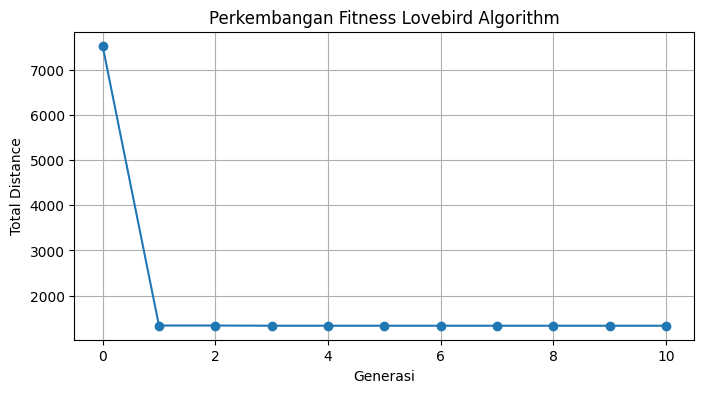

In [170]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_l, marker='o')
plt.title("Perkembangan Fitness Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

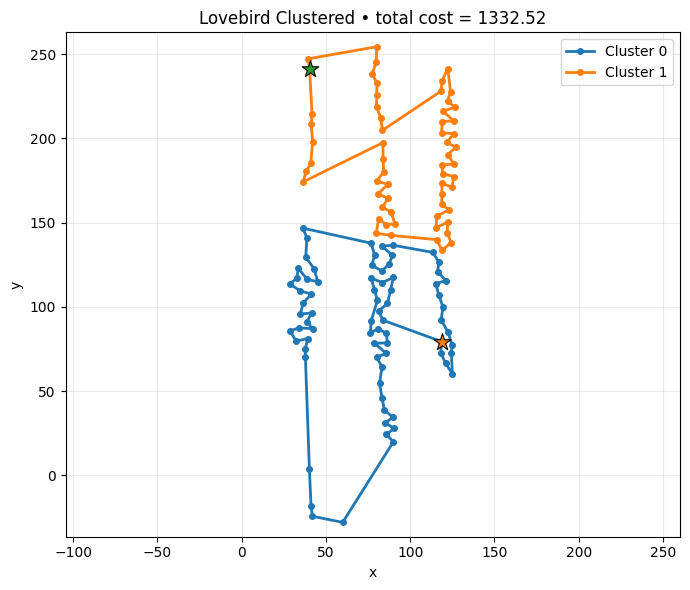

In [171]:
# --- contoh pakai hasil lovebird ---
plot_clustered_routes_matplotlib(
    best_sol_l,
    show_ids=False,
    title=f"Lovebird Clustered • total cost = {total_cost_l:.2f}"
)

# Local Search Algorithm

In [173]:
def two_opt_local_search(
    maxLoop,
    clusters=None,               # <- optional: list of list node IDs per cluster
    labels=None, nodes=None,     # <- optional: jika ada labels dari KMeans + urutan nodes
    initial_solution=None,       # <- optional: seed awal (list of routes)
    time_budget=None,
    check_every=4096
):

    # --- util waktu ---
    t0 = time.perf_counter()
    def time_up():
        return (time_budget is not None) and ((time.perf_counter() - t0) >= time_budget)

    # --- bangun current (list of routes) sesuai prioritas input ---
    if clusters is not None:
        # deep copy, jaga urutan tiap kluster apa adanya
        current = [r[:] for r in clusters if len(r) > 0]
    elif (labels is not None) and (nodes is not None):
        lab = np.asarray(labels)
        K = int(lab.max()) + 1
        tmp = {c: [] for c in range(K)}
        for n, l in zip(nodes, lab):
            tmp[int(l)].append(n)
        # randomisasi urutan dalam kluster
        current = []
        for c in range(K):
            if tmp[c]:
                rc = tmp[c][:]
                random.shuffle(rc)
                current.append(rc)
    elif initial_solution is not None:
        current = [r[:] for r in initial_solution if len(r) > 0]
    else:
        ids_copy = ids[:]
        random.shuffle(ids_copy)
        current = [ids_copy]  # fallback: satu kendaraan

    # Jika tidak ada rute, kembalikan trivial
    if len(current) == 0:
        return [], 0.0, [0.0], []

    # --- biaya awal ---
    route_costs = [total_distance(r) for r in current]
    total_cost  = float(sum(route_costs))
    best_solution = [r[:] for r in current]
    best_fitness = total_cost
    history = [best_fitness]

    EPS = 1e-12
    ops = 0  # throttle untuk pengecekan time_budget

    # --- helper improve satu rute dengan 2-OPT circular (first-improvement) ---
    def _improve_route(route):
        L = len(route)
        if L <= 2:
            return 0.0  # delta total
        total_delta = 0.0
        improved = True
        while improved:
            improved = False
            accepted_outer = False
            i = 0
            while i < L - 1 and not accepted_outer:
                j = i + 1
                while j < L and not accepted_outer:
                    # throttle waktu
                    nonlocal ops
                    ops += 1
                    if (ops % check_every == 0) and time_up():
                        return total_delta  # keluar rapi: kembalikan delta yang sudah terjadi

                    # larang memotong edge yang sama (i=0, j=L-1) karena tour circular
                    if i == 0 and j == L - 1:
                        j += 1
                        continue

                    ap = route[(i - 1) % L]
                    a  = route[i]
                    c  = route[j]
                    dn = route[(j + 1) % L]

                    old = D[idx[ap], idx[a]] + D[idx[c], idx[dn]]
                    new = D[idx[ap], idx[c]] + D[idx[a], idx[dn]]
                    delta = new - old
                    if delta < -EPS:
                        route[i:j+1] = reversed(route[i:j+1])
                        total_delta += delta
                        improved = True
                        accepted_outer = True  # restart dari awal rute
                    else:
                        j += 1
                if not accepted_outer:
                    i += 1
        return total_delta

    # --- main loops ---
    for _ in range(maxLoop):
        if time_up():
            break

        # Turun bukit: improve SEMUA rute (per kluster) sampai lokal optimum
        any_improved = True
        while any_improved and (not time_up()):
            any_improved = False
            for v in range(len(current)):
                if time_up():
                    break
                delta = _improve_route(current[v])
                if abs(delta) > 0.0:
                    route_costs[v] += delta
                    total_cost += delta
                    any_improved = True

        # update best setelah satu fase improve
        if total_cost < best_fitness - EPS:
            best_fitness = float(total_cost)
            best_solution = [rr[:] for rr in current]

        if time_up():
            break

        # Recompute biaya rute & total
        route_costs = [total_distance(rr) for rr in current]
        total_cost = float(sum(route_costs))
        history.append(best_fitness)

    # siapkan ringkasan biaya per kluster untuk best_solution
    per_cluster_costs = [total_distance(r) for r in best_solution]
    best_fitness = float(sum(per_cluster_costs))
    return best_solution, best_fitness, history, per_cluster_costs

In [174]:
best_sol_ll, total_cost_ll, hist_ll, per_costs_ll = two_opt_local_search(
    maxLoop=20,
    labels=labels,
    nodes=nodes,
    time_budget=None
)

print("Biaya per kluster:", per_costs_ll)
print("Total biaya:", total_cost_ll)
for i, r in enumerate(best_sol_ll, 1):
    print(f"Rute kluster {i} (|r|={len(r)}):", r)

Biaya per kluster: [795.058730471534, 603.4965971217921]
Total biaya: 1398.5553275933262
Rute kluster 1 (|r|=75): [27, 51, 80, 10, 117, 52, 110, 54, 29, 133, 4, 42, 103, 11, 26, 95, 111, 63, 23, 107, 34, 72, 40, 106, 81, 15, 93, 62, 37, 124, 21, 129, 67, 123, 43, 50, 101, 130, 1, 71, 55, 30, 115, 47, 88, 77, 20, 76, 60, 16, 85, 6, 41, 116, 69, 18, 108, 44, 128, 58, 78, 38, 84, 8, 112, 96, 132, 135, 53, 125, 3, 114, 90, 82, 59]
Rute kluster 2 (|r|=60): [46, 19, 118, 68, 33, 89, 13, 102, 134, 73, 109, 28, 121, 87, 122, 57, 14, 83, 31, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105, 36, 91, 5, 97, 119, 75, 2, 66, 74, 39, 104, 113, 64, 25, 120, 70, 12, 92, 32, 127, 48, 98, 131, 100, 126, 61, 45]


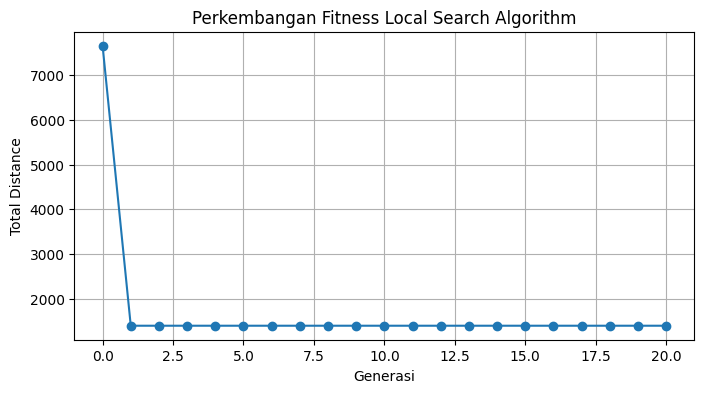

In [175]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_ll, marker='o')
plt.title("Perkembangan Fitness Local Search Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

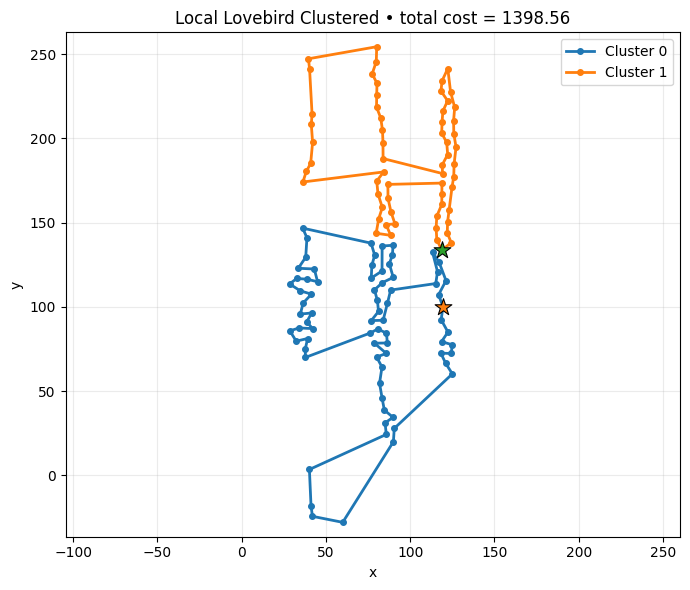

In [176]:
# --- contoh pakai hasil lovebird ---
plot_clustered_routes_matplotlib(
    best_sol_ll,
    show_ids=False,
    title=f"Local Lovebird Clustered • total cost = {total_cost_ll:.2f}"
)